In [1]:
# TODO: Make it more generic so that when other people use the code they can use it without
# changing anything
# Add the paths that facenet is in
import sys
sys.path.insert(0, "/Users/kevinlu/Documents/Facial-Recognition/custom_facenet/src")
sys.path.insert(0, "/Users/kevinlu/Documents/Facial-Recognition/custom_facenet/src/align")


['', '/Users/kevinlu/miniconda3/envs/facial_recognition/lib/python35.zip', '/Users/kevinlu/miniconda3/envs/facial_recognition/lib/python3.5', '/Users/kevinlu/miniconda3/envs/facial_recognition/lib/python3.5/plat-darwin', '/Users/kevinlu/miniconda3/envs/facial_recognition/lib/python3.5/lib-dynload', '/Users/kevinlu/miniconda3/envs/facial_recognition/lib/python3.5/site-packages', '/Users/kevinlu/miniconda3/envs/facial_recognition/lib/python3.5/site-packages/mayavi-4.5.0-py3.5-macosx-10.6-x86_64.egg', '/Users/kevinlu/miniconda3/envs/facial_recognition/lib/python3.5/site-packages/setuptools-27.2.0-py3.5.egg', '/Users/kevinlu/miniconda3/envs/facial_recognition/lib/python3.5/site-packages/IPython/extensions', '/Users/kevinlu/.ipython']


In [4]:
import os
import sklearn
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import detect_face
import facenet
import tensorflow as tf # NOTE: this has to use Tensorflow version 1.x
import numpy as np
import cv2
import scipy as sp
import glob
import copy
import dlib
import math
from skimage import io
%matplotlib inline

## Setup

### Get the images first

In [5]:
image_paths =  glob.glob("/Users/kevinlu/Documents/datasets/lfw_filtered/**/*.jpg")
# image_paths = ["/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0016.jpg"]
print(image_paths)

['/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0001.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0002.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0003.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0004.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0005.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0006.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0007.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0008.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0010.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0012.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0013.jpg', '/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abd

In [6]:
class Face:
    """
    This is a data structure to store the faces and the relevant information to cluster it later on
    
    :: face_image is the image of the resized face
    :: image_path is the image path of the photo that the face was extracted from
    :: name_of_face is the name of the face and used to test our accuracy
    :: original_image_with_bounding_box is the original image with a box drawn around the face
    :: embedding is the 128 dimension embedding in the a unit sphere
    :: label is the cluster label that was assigned to this face
    """
    def __init__(self, face_image, image_path, name_of_face, landmarks = None,\
                 euclidean_neighbours = None, rank_order_neighbours = None,  \
                 original_image_with_bounding_box = None,\
                 embedding = None, label = None):
        
        self.face_image = face_image
        self.image_path = image_path # this is the image path that contains the photo 
                                     # this face is located in
            
        self.name_of_face = name_of_face
        self.landmarks = landmarks
        self.euclidean_neighbours = euclidean_neighbours
        self.rank_order_neighbours = rank_order_neighbours
        self.original_image_with_bounding_box = original_image_with_bounding_box
        self.embedding = embedding
        self.label = label
    
    def __str__(self):
        return("Name: {}\nLabel: {}".format(self.name_of_face, self.label))

## Face detection/alignment

### Method 1: 
* Facial Detection: regression trees 
* Landmark Detection: regression trees
* Facial Alignment: Delaunay Triangulation

In [7]:
def draw_point(image, point, color = (255, 0, 0)):
    point = (int(point[0]), int(point[1]))
    cv2.circle(image, point, 2, color, -2)

def similarity_transform(inPoints, outPoints):
    s60 = math.sin(60*math.pi/180)
    c60 = math.cos(60*math.pi/180)


    inPts = np.copy(inPoints).tolist()
    outPts = np.copy(outPoints).tolist()

    # Find the point for an equilateral triangle
    
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]
    
    inPts.append([np.int(xin), np.int(yin)])
    
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]
    
    outPts.append([np.int(xout), np.int(yout)]);
#     print("hi")
#     print(inPts)
#     print(outPts)
    
    tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False)
    
    return tform

def get_landmark_points(pose_landmarks, dlib_point = True):
    landmarks = []
    n = 68
    for i in range(n): 
        point = pose_landmarks.part(i)
        if dlib_point:
            landmark = point
        else:
            landmark = [point.x, point.y]
        landmarks.append(landmark) 
    return(landmarks)


In [11]:
def find_faces_1(image_path):
    
    # Setup the models
    face_detector = dlib.get_frontal_face_detector() 
    predictor_model = "shape_predictor_68_face_landmarks.dat"
    face_pose_predictor = dlib.shape_predictor(predictor_model)

    # Define the variables needed for the affine transform
    w, h = 160, 160
    boundary_points = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ])
    eye_corner_dst = [[np.int(0.3 * w), np.int(h / 3)],\
       [np.int(0.7 * w), np.int(h / 3)]]

    # Get an image and find the faces
    image = mpimg.imread(image_path)[:,:,0:3].astype(np.uint8)
    detected_face = face_detector(image)
    faces = []
    #     plt.imshow(image)
    #     return

    # Find the faces in this image
    print("Number of face detected is: {}".format(len(detected_face)))
    for face_rect in detected_face:
        print("image.shape is;")
        print(image.shape)
        # First crop the face
        left = max(0, face_rect.left())
        top = max(0, face_rect.top())
        right = min(image.shape[1], face_rect.right())
        bottom = min(image.shape[0], face_rect.bottom())
        print(left, top, right, bottom)

        new_face_rect = dlib.rectangle(0, 0, right-left, bottom-top)
        cropped_image = copy.deepcopy(image)[top:bottom, left:right, :].astype(np.uint8)
        print(cropped_image.shape)

        # Get the the landmarks for the face
        pose_landmarks = face_pose_predictor(cropped_image, new_face_rect)

        # Append the landmarks that are found to a list
        landmarks = get_landmark_points(pose_landmarks, dlib_point=False)

        # Get source points
        left_eye = landmarks[36]
        right_eye = landmarks[45]
        eye_corner_src = [left_eye, right_eye]

        # Compute similarity transform
        transform = similarity_transform(eye_corner_src, eye_corner_dst)

        # Apply similarity transform on image
        print(cropped_image.shape)
        #         print(transform.shape)
        cropped_image_t = cv2.warpAffine(cropped_image, transform, (w, h))
        #         plt.imshow(img)

        # Apply similarity transform points
        # Note here rs stands for reshape, t for transformed
        landmarks_rs = np.reshape(np.array(landmarks), (68, 1, 2))
        landmarks_t = cv2.transform(landmarks_rs, transform)

        # Append boundary points. Which will be used in Delaunay triangulation
        landmarks_t = np.float32(np.reshape(landmarks_t, (68, 2)))
        landmarks_t = np.append(landmarks_t, boundary_points, axis = 0)

        name_of_face = image_path.split("/")[6]
        face = Face(cropped_image_t, image_path, name_of_face, landmarks_t)
        faces.append(face)
    return(faces)
       

In [12]:
# Get all the face objects into one array
all_faces = []
for i, image_path in enumerate(image_paths):
    print(image_path)
    faces_in_image = find_faces_1(image_path)
    all_faces.append(faces_in_image)
    break
all_faces = np.concatenate(np.array(all_faces))

/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0001.jpg
Number of face detected is: 1
image.shape is;
(250, 250, 3)
76 76 180 180
(104, 104, 3)
(104, 104, 3)


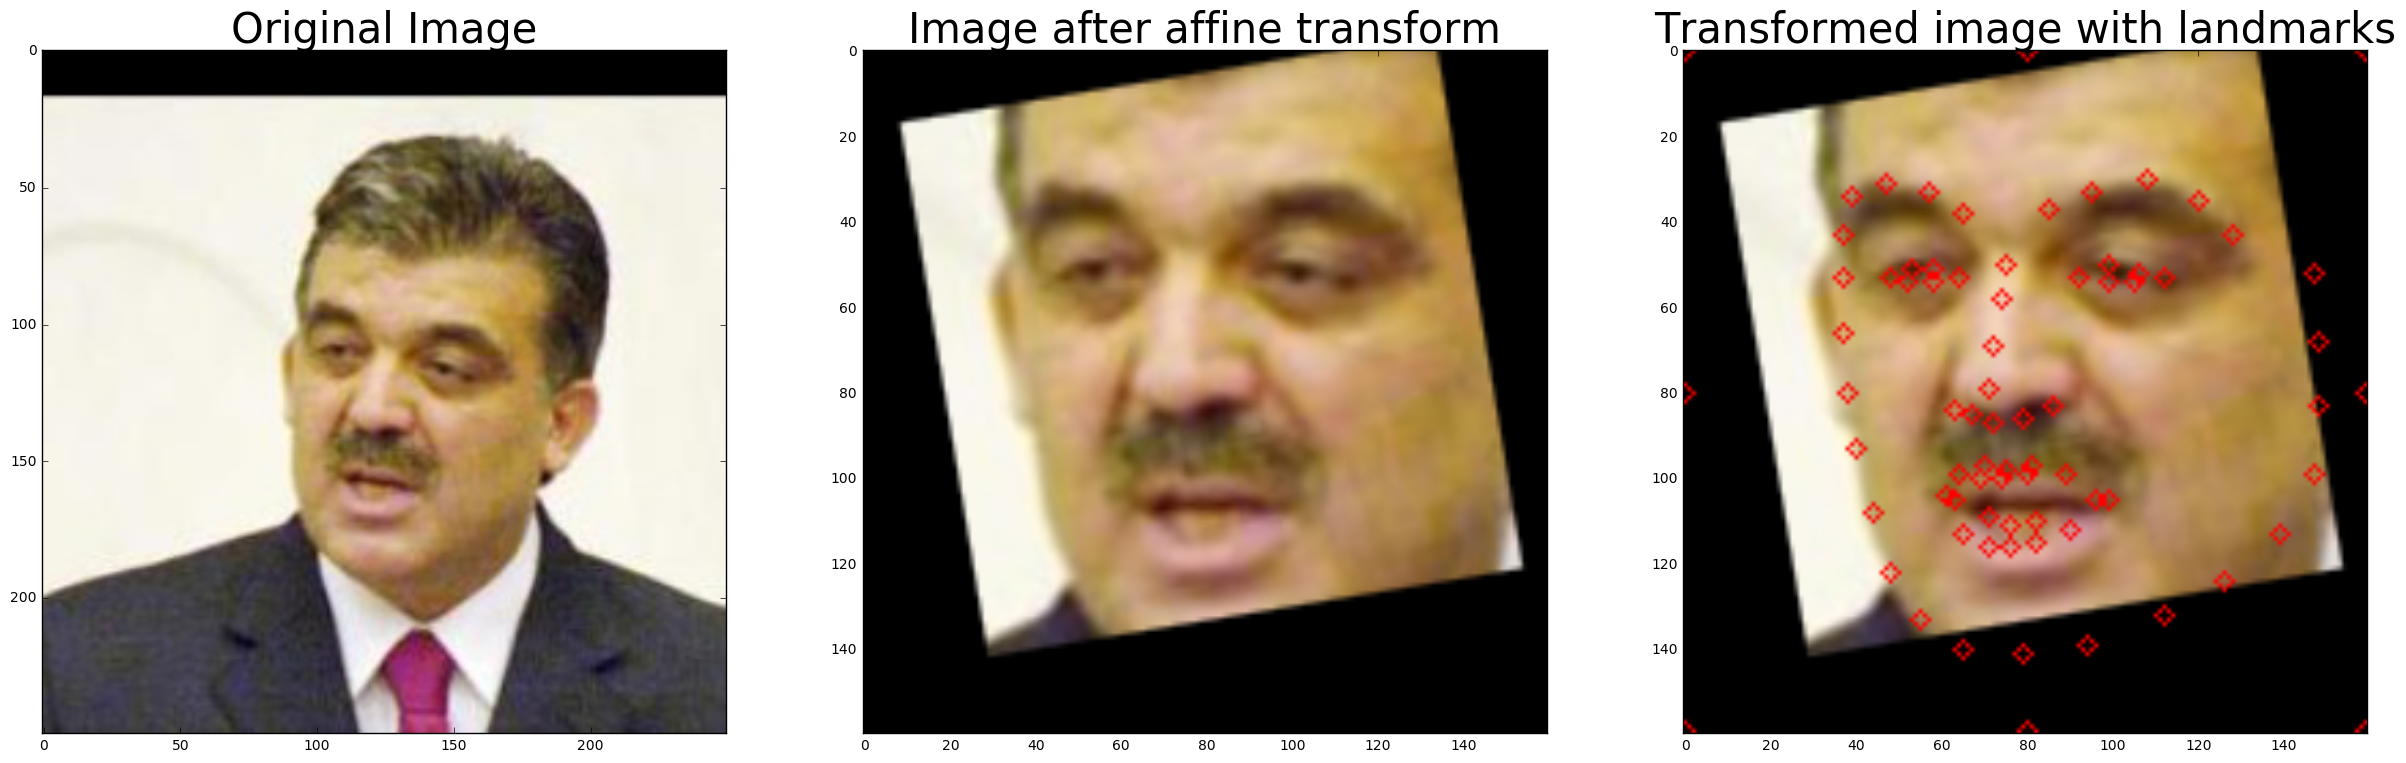

In [13]:
image = mpimg.imread(image_paths[0])[:,:,0:3].astype(np.uint8)
temp_face = copy.deepcopy(all_faces[0].face_image)
for landmark in all_faces[0].landmarks:
    cv2.circle(temp_face, (int(landmark[0]), int(landmark[1])), 2, (255, 0, 0))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 30))
ax1.imshow(image)
ax1.set_title("Original Image", fontsize = 30)
ax2.imshow(all_faces[0].face_image)
ax2.set_title("Image after affine transform", fontsize = 30)
ax3.imshow(temp_face)
ax3.set_title("Transformed image with landmarks", fontsize = 30)

#### Calibration for affine transform

Saving landmarks to: landmarks_dst.p


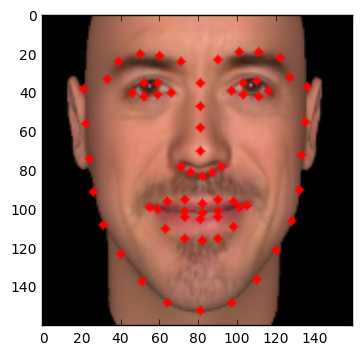

In [14]:
# Setup some parameters for the landmark calibration
import pickle
predictor_model = "shape_predictor_68_face_landmarks.dat"
N_LANDMARKS = 68

w, h = 160, 160 # needed for facenet

# Destination for final transform
eye_corner_dst = [[np.int(0.3 * w), np.int(h / 3)],\
                   [np.int(0.7 * w), np.int(h / 3)]]
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)
boundary_points = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ])

image = cv2.resize(mpimg.imread("Images/dest_landmarks_calib.jpg")[:,:,0:3].astype(np.uint8), (160, 160))



new_face_rect = dlib.rectangle(0, 0, image.shape[1], image.shape[0])

# Get the the face's pose
pose_landmarks = face_pose_predictor(image, new_face_rect)

# Append the landmarks that are found to a list
landmarks = get_landmark_points(pose_landmarks, dlib_point=False)

for landmark in landmarks:
    draw_point(image, (landmark[0], landmark[1]))

# landmarks = np.append(landmarks, boundary_points, axis = 0)
# print(landmarks)
plt.imshow(image)

# Save the landmarks 
pickle_save_file = "landmarks_dst.p"
print("Saving landmarks to: {}".format(pickle_save_file))
pickle.dump({"landmarks_dst" : landmarks}, open(pickle_save_file, "wb")) 

In [15]:
def calculateDelaunayTriangles(rect, points):
    
    # Create subdiv
    subdiv = cv2.Subdiv2D(rect)
    
    # Insert points that correspond to the average landmark location on the transformed
    # space into subdiv 
#     print("There are {} points".format(len(points)))
    for p in points:
#         print("inserting point: {}".format(p))
        subdiv.insert((p[0], p[1]))
    
    # List of triangles these are the triangles that are created by the inserted ponts. 
    # Each triangle is a list of 3 points (6 numbers)
    triangleList = subdiv.getTriangleList()
    
    delaunayTri = []
    
    # Find the points/vertices of the triangles
    for triangle in triangleList:
        pt = []
        pt.append((triangle[0], triangle[1]))
        pt.append((triangle[2], triangle[3]))
        pt.append((triangle[4], triangle[5]))
        
        pt1 = (triangle[0], triangle[1])
        pt2 = (triangle[2], triangle[3])
        pt3 = (triangle[4], triangle[5])
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            # If the points that make up the triangle are in the rectangle, 
            # find the indexes of those points so that they can be accessed via points[<index>]
            # where points is the array of all destination (or in our case avg) points.
            for j in range(3):
                for k in range(len(points)):
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and\
                       abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)
            if len(ind) == 3:
                delaunayTri.append((ind[0], ind[1], ind[2]))
    return(delaunayTri)

def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

def constrainPoint(p, w, h) :
    p =  ( min( max( p[0], 0 ) , w - 1 ) , min( max( p[1], 0 ) , h - 1 ) )
    return p;

def warpTriangle(img1, img2, t1, t2):
    """
    img1 an image that has been affine transformed
    img2 is an empty img
    t1 is triangleIn which is a triangle made from the landmark points int he affine transformed image
    t2 is triangleOut which are the destination landmark points
    
    The goal is to map img1 to img2 triangle by triangle, and calculating an affine transform to match
    one triangle to the other
    """
    
    # Find the bounding rectangle for each triangle, the reason for this is that we need it to make a mask
    # for the triangle that is going to make up the final image
    r1 = cv2.boundingRect(np.float32([t1])) # r1[0] = x,  r1[1] = y, r1[2] = w, r1[3] = h
    r2 = cv2.boundingRect(np.float32([t2]))
    
    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    t2RectInt = []
    zeros = np.zeros_like(img1)
    
    for i in range(3):
        t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
#     print(t1Rect)
#     for i in range(3):
#         t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
#         t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
#         t2RectInt.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
        
    # Get mask by filling triangle, note that a mask is simply an area that is "active"
    # when multiplied by another image of the same dimensions
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32) # Getting a mask same size as r2
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0) # fill in the triangle
    
    # Apply warp a small rectangle on img1, the resulting warped rectangle is the rectangle for img2
    img1Rect = img1[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]
    
    size = (r2[2], r2[3])
    
    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
#     plt.imshow(img2Rect)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))
#     ax1.imshow(img1Rect)
    img2Rect = img2Rect * mask
#     plt.imshow(mask)
    
    # Copy triangular region of the rectangular patch to the output image
    
    # This inverts the mask so that the white area becomes black, and black becomes white
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask ) 
    
#     plt.imshow((1.0, 1.0, 1.0) - mask)

    # Now add the img2Rect, which is the triangle that is surrounded by black
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect

def applyAffineTransform(src, srcTri, dstTri, size):

    print(srcTri, dstTri)
    # Given a pair of triangles find the affine transform
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

    # Apply the affine Transform found to src image
    dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None,\
                         flags = cv2.INTER_LINEAR,borderMode=cv2.BORDER_REFLECT_101)
    return(dst)


In [16]:
def align_face(face):
    # # Define the final image shape
    w, h = 160, 160
    rect = (0, 0, w, h)
    
    # Get the delaunayTriangles
    landmarks_dst = pickle.load(open("landmarks_dst.p", "rb"))["landmarks_dst"]
    dt = calculateDelaunayTriangles(rect, np.array(landmarks_dst))
    
    # Get the transformed landmarks
    landmarks_t = face.landmarks
    
    # Get the transformed image of the face
    face_image = face.face_image.copy()

    # Output image
    output = np.zeros((h, w, 3), np.float32())

    # Transform the triangles one by one
    for j in range(len(dt)):
        triangleIn = []
        triangleOut = []

        # So here we are getting the jth triangle (remember this this 
        # is a 3-tuple with each tuple corresponding to an index which 
        # can be used to find a point in landmarks_t or dst_landmarks)
        for k in range(3):
            pointIn = landmarks_t[dt[j][k]]
            pointIn = constrainPoint(pointIn, w, h)

            pointOut = landmarks_dst[dt[j][k]] # replace this with the set landmark coordinates
            pointOut = constrainPoint(pointOut, w, h)

            triangleIn.append(pointIn)
            triangleOut.append(pointOut)

        # Now draw on the new image
        warpTriangle(face_image, output, triangleIn, triangleOut)
    return(output.astype(np.uint8))

[(9.0, 19.0), (0.0, 0.0), (14.0, 17.0)] [(7, 16), (0, 0), (13, 11)]
[(2.0, 0.0), (11.0, 19.0), (0.0, 9.0)] [(6, 0), (13, 16), (0, 9)]
[(0.0, 1.0), (6.0, 0.0), (6.0, 5.0)] [(0, 1), (9, 0), (9, 11)]
[(8.0, 10.0), (2.0, 11.0), (0.0, 0.0)] [(9, 2), (0, 3), (1, 0)]
[(0.0, 23.0), (0.0, 10.0), (0.0, 0.0)] [(1, 23), (0, 5), (12, 0)]
[(11.0, 0.0), (0.0, 24.0), (6.0, 0.0)] [(18, 1), (0, 33), (9, 0)]
[(0.0, 24.0), (11.0, 0.0), (14.0, 25.0)] [(0, 32), (18, 0), (17, 36)]
[(1.0, 26.0), (0.0, 12.0), (15.0, 0.0)] [(2, 32), (0, 14), (30, 0)]
[(0.0, 0.0), (7.0, 11.0), (2.0, 9.0)] [(0, 0), (8, 4), (0, 3)]
[(7.0, 11.0), (0.0, 0.0), (5.0, 0.0)] [(8, 4), (0, 0), (9, 1)]
[(2.0, 13.0), (0.0, 0.0), (23.0, 24.0)] [(2, 17), (0, 0), (31, 25)]
[(5.0, 1.0), (7.0, 10.0), (0.0, 0.0)] [(9, 5), (9, 8), (0, 0)]
[(4.0, 15.0), (0.0, 0.0), (21.0, 11.0)] [(5, 17), (0, 0), (29, 8)]
[(7.0, 13.0), (0.0, 0.0), (4.0, 1.0)] [(2, 17), (0, 0), (5, 3)]
[(0.0, 0.0), (7.0, 13.0), (1.0, 15.0)] [(7, 0), (9, 17), (0, 18)]
[(4.0, 18.0), (

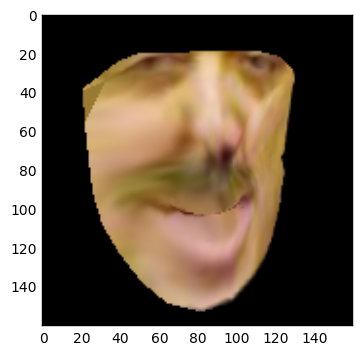

In [19]:
# Setup the face images
for face in all_faces:
    face.face_image = align_face(face)

plt.imshow(all_faces[0].face_image)

### Method 2: 
* Facial Detection: [MTCNN](https://kpzhang93.github.io/MTCNN_face_detection_alignment/)
* Landmark Detection: None
* Facial Alignment: [MTCNN](https://kpzhang93.github.io/MTCNN_face_detection_alignment/)

In [22]:
def find_faces_2(image_paths, include_bounding_box_image = False):
    
    # Set the parameter values needed for MTCNN
    minsize = 20 # minimum size of face
    threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
    factor = 0.709 # scale factor used for the pyramid
    margin = 20 # the margin around the bboxes
    output_image_size = 160 # 160 x 160 is the image size that facenet requires
    
    # Get the image size
    sample_image = mpimg.imread(image_paths[0])
    img_size = sample_image.shape
    
    # Storage of all the faces 
    all_faces = []
    all_face_original_image = []
    # Initialize the MTCNN networks
    with tf.Graph().as_default():
        ## TODO: GPU options
        # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=<gpu_memory_fraction>)
        sess = tf.Session()
        with sess.as_default():
            pnet, rnet, onet = detect_face.create_mtcnn(sess, None)

        for image_path in image_paths:
        
            # Read in the image
            image = mpimg.imread(image_path)
            
            # Now find the bboxes
            bboxes,_ = detect_face.detect_face(image, minsize, pnet, rnet, onet, threshold, factor)
            bboxes = bboxes[:, 0:4] # get the x1, y1, x2, y2 for the corners


            for bbox in bboxes:

                # Apply margins while confining the bboxes to be contained 
                # within the dimensions of the image
                bbox[0] = np.maximum(bbox[0]-margin/2, 0)
                bbox[1] = np.maximum(bbox[1]-margin/2, 0)
                bbox[2] = np.minimum(bbox[2]+margin/2, img_size[1])
                bbox[3] = np.minimum(bbox[3]+margin/2, img_size[0])
                bbox = bbox.astype(np.int32)

                # Get the face
                face_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2],:]

                # Resize the face to a size that facenet can use
                face_resized = sp.misc.imresize(face_image, (output_image_size, output_image_size), interp = 'bilinear')
                
                name_of_face = image_path.split("/")[6]
#                 name_of_face = "HI"
#                 print("name_of_face is: {}".format(name_of_face))               
                
                # Add the face to the array for later use
                if include_bounding_box_image:
                    temp_image = copy.deepcopy(image)  
                    original_image_with_bounding_box = cv2.rectangle(temp_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]),\
                                                                                        color = (0, 0, 255), thickness = 5)
                    face = Face(face_resized, image_path, name_of_face, original_image_with_bounding_box=original_image_with_bounding_box)
                else:                
                    face = Face(face_resized, image_path, name_of_face)
                all_faces.append(face)
                
    return(np.array(all_faces))

In [ ]:
all_faces = find_faces_2(image_paths)
print(len(all_faces))

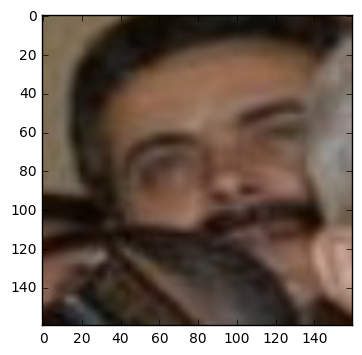

In [51]:
plt.imshow(all_faces[9].face_image)

### Method 3:  
* Facial detection: regression trees
* Landmark detection: regression trees 
* Alignment: method used in [Clustering Millions of Faces by Identity](https://arxiv.org/pdf/1604.00989.pdf) to align faces need to fix

In [25]:
def find_rotation_angle(landmarks):
    # Rotate image so that the eyes are aligned
    left_eye_corner = landmarks[36]
    right_eye_corner = landmarks[45] 
    opp = right_eye_corner[1] - left_eye_corner[1]
    adj = right_eye_corner[0] - left_eye_corner[0]
    angle = np.arctan(opp/adj)*180/np.pi
    return(angle)
def find_rotation_matrix(image, angle):
    h, w = image.shape[0:2]
    center = tuple(np.array([h, w])/2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1)
    return(rot_mat)
def rotate_image(image, angle):
    h, w = image.shape[0:2]
    center = tuple(np.array([h, w])/2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1)
    image = cv2.warpAffine(image, rot_mat, (w, h))
    return(image, rot_mat)
def transform_2dpoints(points, rot_mat):
#     points_rs = np.reshape(np.array(points), (68, 1, 2))
    num_points = len(points)
    points_rs = np.expand_dims(np.array(points), 1)
    points_t = cv2.transform(points_rs, rot_mat)
    points_t = np.float32(np.reshape(points_t, (num_points, 2)))
    return(points_t)

def find_bbox_points(image, landmarks, margin_ratio):
    h, w = image.shape[0:2]
    
    left = max(0, min([landmark[0] for landmark in landmarks]))
    right = min(w, max([landmark[0] for landmark in landmarks]))
    lr_diff = right - left
    left = max(0, left - lr_diff * margin_ratio)
    right = min(w, right + lr_diff * margin_ratio)
    
    top = max(0, min([landmark[1] for landmark in landmarks]))
    bottom = min(h, max([landmark[1] for landmark in landmarks]))
    tb_diff = bottom - top
    top = max(0, top - tb_diff * margin_ratio)
    bottom = min(h, bottom + tb_diff * margin_ratio)
    
    return (int(left), int(top)), (int(right), int(bottom))
def get_centers_for_landmarks(landmarks):
    # Center of image
    left_most = landmarks[np.argmin(landmarks[:, 0])]
    right_most = landmarks[np.argmax(landmarks[:, 0])]
  
    face_center = ((left_most+right_most)/2).astype(np.int32)
    
    # Get the center of the eyes and mouth
    eye_area = np.concatenate((landmarks[36:42], landmarks[42:48]), axis = 0)
    eye_center = np.mean(eye_area, axis = 0).astype(np.int32)
    
    mouth_area = landmarks[48:68]
    mouth_center = np.mean(mouth_area, axis = 0).astype(np.int32)
    return([face_center, eye_center, mouth_center])


def find_center_transform(image, face_center):
    h, w = image.shape[0:2]
    center_dx = int(w/2) - face_center[0] # if face_center[0] > w/2 then it means that image 
                                          # will shift left
    center_dy = int(h/2) - face_center[1] # if face_center[1] > h/2 then it means that image 
                                          # will shift 
    M = np.float32([[1,0,center_dx],[0,1,center_dy]])
    return(M)

def center_image_on_face(image, center_matrix):
    h, w = image.shape[0:2]
    # Centered image
    return(cv2.warpAffine(image, center_matrix, (w, h)))

def similarity_transform(inPoints, outPoints):
    s60 = math.sin(60*math.pi/180)
    c60 = math.cos(60*math.pi/180)


    inPts = np.copy(inPoints).tolist()
    outPts = np.copy(outPoints).tolist()

    # Find the point for an equilateral triangle
    
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]
    
    inPts.append([np.int(xin), np.int(yin)])
    
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]
    
    outPts.append([np.int(xout), np.int(yout)]);
#     print("hi")
#     print(inPts)
#     print(outPts)
    
    tform = cv2.estimateRigidTransform(np.array([inPts]).astype(np.float32), np.array([outPts]).astype(np.float32), False)
    
    return tform

def draw_landmarks(image, landmarks):
    for landmark in landmarks:
        draw_point(image, landmark)
    return(image)

In [26]:
# ### DEBUG VERSION ### 
# # Setup the models
# from scipy import ndimage
# face_detector = dlib.get_frontal_face_detector() 
# predictor_model = "shape_predictor_68_face_landmarks.dat"
# face_pose_predictor = dlib.shape_predictor(predictor_model)

# # Define the variables needed for the affine transform
# # w, h = 160, 160
# margin = 100
# # Get an image and find the faces
# # image = mpimg.imread(image_paths[0])
# image = mpimg.imread("Images/Will_Ferrell_2.jpg")[...,:3].astype(np.uint8)
# detected_face = face_detector(image)
# # print("Number of face detected is: {}".format(len(detected_face)))
# faces = []

# # Get the bounding box for the face
# for i, face_rect in enumerate(detected_face):
# #     if i == 0:
# #         continue
    
#     temp_image = copy.deepcopy(image)
#     h, w = temp_image.shape[0:2]
   
#     # Get the landmarks
#     pose_landmarks = face_pose_predictor(image, face_rect)
#     landmarks = get_landmark_points(pose_landmarks, dlib_point=False)
    
#     # Uncomment to draw the landmarks on the image
# #     for landmark in landmarks:
# #         draw_point(temp_image, landmark)

#     # Rotate image so that the eyes are aligned
#     angle = find_rotation_angle(landmarks)
#     rot_mat = find_rotation_matrix(image, angle)
#     temp_image = cv2.warpAffine(image, rot_mat, (w, h))
    
#     # Rotate the facial features to create a bbox for the face
#     landmarks = transform_2dpoints(landmarks, rot_mat)

# #     Verify that the landmarks have been transformed properly
#     for landmark in landmarks:
# #         print(landmark)
#         draw_point(temp_image, landmark, color=(0, 255, 0))
        
# #     # Now extract the face to resize it first, get a bounding box for the face
# #     left, right, top, bottom = find_bbox_points(landmarks)
# #     temp_image = temp_image[top:bottom, left:right]
    
   
#     center_points_src = get_centers_for_landmarks(landmarks)

    
#     # Do affine transform to center the image
#     center_matrix = find_center_transform(temp_image, center_points_src[0]) 
#     temp_image = center_image_on_face(temp_image, center_matrix)
    
#     # Update the center points
#     center_points_src = transform_2dpoints(center_points_src, center_matrix)
#     cv2.circle(temp_image, tuple(center_points_src[0]), 5, (0,0, 255), -5) 
#     cv2.circle(temp_image, tuple(center_points_src[1]), 5, (255,0,0), -5)
#     cv2.circle(temp_image, tuple(center_points_src[2]), 5, (255, 0, 0), -5)
    
# #     plt.imshow(temp_image)
    
#     # Get the target points for the affine transform
#     print(w, h)
#     face_center_dst = [center_points_src[0][1], center_points_src[0][0]]
#     eye_center_dst = [center_points_src[1][0], h * 0.45]
#     mouth_center_dst = [center_points_src[2][0], h * 0.75]
    
#     center_points_dst = np.array([face_center_dst, eye_center_dst, mouth_center_dst]).astype(np.float32)
    
#     print("Source points")
#     print(center_points_src)
#     print("Destination points")
#     print(center_points_dst)
# #     plt.imshow(temp_image)
#     M = cv2.getAffineTransform(center_points_src, center_points_dst)
# #     M = np.array([[1.5, face_center_dst[1], 0],[face_center_dst[0], 1.5, 0]])
# #     M = np.array([[1.5, 0, -face_center_dst[1]], [0, 1.5, -face_center_dst[0]]])
# #     M = np.array([[1.5, 0, -face_center_dst[1]/2], [0, 1.5, -face_center_dst[0]/2]])
# #     print(M)
#     temp_image = cv2.warpAffine(temp_image, M, (w, h))
#     plt.imshow(temp_image)
    
#     break
# #     print(bbox)

In [27]:
# Setup the models
from scipy import ndimage

def find_faces_3(image_paths, include_bounding_box_image = False):
    face_detector = dlib.get_frontal_face_detector() 
    predictor_model = "shape_predictor_68_face_landmarks.dat"
    face_pose_predictor = dlib.shape_predictor(predictor_model) 
    faces = []
    
    for image_path in image_paths:
        print(image_path)
        image = mpimg.imread(image_path).astype(np.uint8)[:,:,0:3]
        detected_faces = face_detector(image)


        # Get the bounding box for the face
        for i, face_rect in enumerate(detected_faces):
        #     if i == 1:
        #         continue

            temp_image = copy.deepcopy(image)
            h, w = temp_image.shape[0:2]

            # Get the landmarks
            pose_landmarks = face_pose_predictor(temp_image, face_rect)
            landmarks = get_landmark_points(pose_landmarks, dlib_point=False)
        #     left, right, top, bottom = find_bbox_points(landmarks)
        #     temp_image = temp_image[top:bottom, left:right]

            # Rotate image so that the eyes are aligned
            angle = find_rotation_angle(landmarks)
            rot_mat = find_rotation_matrix(image, angle)
            temp_image = cv2.warpAffine(temp_image, rot_mat, (w, h))

            # Rotate the facial features to create a bbox for the face
            landmarks = transform_2dpoints(landmarks, rot_mat)   
            
            # Fidn the centers for the face
            center_points_src = get_centers_for_landmarks(landmarks)

        #     # Do affine transform to center the image
            center_transform = find_center_transform(temp_image, center_points_src[0]) 
            temp_image = center_image_on_face(temp_image, center_transform)

            # Update the center points and landmark points
            center_points_src = transform_2dpoints(center_points_src, center_transform)
            landmarks = transform_2dpoints(landmarks, center_transform)

            # Get the target points for the affine transform to make the eye and mouth at same position
            # for all the images
            eye_center_dst = [float(center_points_src[1][0]), h * 0.45]
            mouth_center_dst = [float(center_points_src[2][0]), h * 0.75]
        #     print(eye_center_dst)
        #     print(mouth_center_dst)
#             print(center_points_src)

            alignment_transform = similarity_transform([center_points_src[1], center_points_src[2]], [eye_center_dst, mouth_center_dst])
            temp_image = cv2.warpAffine(temp_image, alignment_transform, (w, h)) 
            landmarks = transform_2dpoints(landmarks, alignment_transform) 
            center_points_src = transform_2dpoints(center_points_src, alignment_transform)    

          # Update the center points and landmark points
        #     landmarks = transform_2dpoints(landmarks, alignment_transform)

            top_corner, bottom_corner = find_bbox_points(temp_image, landmarks, 0.1)
        #     cv2.rectangle(temp_image, top_corner, bottom_corner, (255, 0, 0), 3)   
            face_image = temp_image[top_corner[1]:bottom_corner[1], top_corner[0]:bottom_corner[0]]
            face_resized = cv2.resize(face_image, (160, 160))
            name_of_face = image_path.split("/")[6]
            

            if include_bounding_box_image:
                original_image_with_bounding_box = cv2.rectangle(face_image, top_corner, bottom_corner,\
                                                                                    color = (0, 0, 255), thickness = 5)
                face = Face(face_resized, image_path, name_of_face, original_image_with_bounding_box=original_image_with_bounding_box)
            else:                
                face = Face(face_resized, image_path, name_of_face)
        faces.append(face)
    return(np.array(faces))
    
#     print(bbox)

In [28]:
all_faces = find_faces_3(image_paths, include_bounding_box_image=True)

/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0001.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0002.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0003.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0004.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0005.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0006.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0007.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0008.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0010.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0012.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0013.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0014.jpg
/Users/kevinlu/D

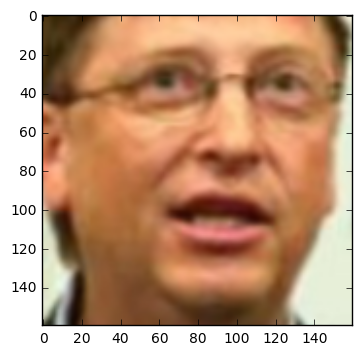

In [29]:
plt.imshow(all_faces[30].face_image)

## Finding the embeddings

### Using FaceNet

In [30]:
MODEL_DIR = "20170216-091149"
def load_embedding_layer_for_facenet():
    # Now utilize facenet to find the embeddings of the faces
    # Get the save files for the models
    meta_file, ckpt_file = facenet.get_model_filenames(MODEL_DIR)
    with tf.Graph().as_default():
        with tf.Session().as_default() as sess:
            model_dir_exp = os.path.expanduser(MODEL_DIR)
            print("importing graph")
            saver = tf.train.import_meta_graph(os.path.join(model_dir_exp, meta_file))
            print("restoring session")
            saver.restore(tf.get_default_session(), os.path.join(model_dir_exp, ckpt_file))
            images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
            embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
            find_embeddings = lambda img : sess.run(embeddings, feed_dict = {images_placeholder : img, phase_train_placeholder : False})
    return(find_embeddings)


In [31]:
def find_embeddings(embedding_layer, face_images, batch_size = 10):
    ## TODO: Do this with image paths instead of images make the algorithm only read in the images it needs rather
    # than storing all the images
    

    # Get the save files for the models
    n_images = len(face_images)
    n_batches = int(np.ceil(float(n_images)/batch_size)) 
    
    ## TODO: Test whether np.zeros((n_images, 128)), then filling in the zeros, or whether using an empty list, 
    # appending to it then converting it to a np.array() is faster
    face_embeddings = np.zeros((n_images,128))
    #     face_embeddings = []

    for i in range(n_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, n_images)

        # Get the embeddings
        face_embeddings[start:end, :] = embedding_layer(face_images[start:end])
    return(face_embeddings)

In [32]:
# Load the embeddings layer from facenet
facenet_embedding_layer = load_embedding_layer_for_facenet()

importing graph
restoring session


/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0001.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0002.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0003.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0004.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0005.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0006.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0007.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0008.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0010.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0012.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0013.jpg
/Users/kevinlu/Documents/datasets/lfw_filtered/Abdullah_Gul/Abdullah_Gul_0014.jpg
/Users/kevinlu/D

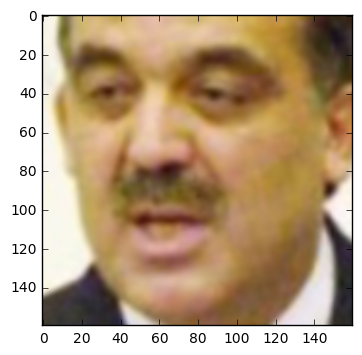

In [74]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Get all the face images
all_faces = find_faces_3(image_paths)
face_images = np.array([face.face_image for face in all_faces])
plt.imshow(face_images[0])
print(len(face_images))

In [75]:
# prewhiten the image
def prewhiten(x):
    # just normalizing the image
    mean = np.mean(x) # mean of all elements
    std = np.std(x) # std of all elements
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size)) # get the max between the std, and 1/sqrt(number_of_all_elements)
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return(y)

face_images = np.array([prewhiten(face) for face in face_images])

In [76]:
# Calculate the embeddings
face_embeddings = find_embeddings(facenet_embedding_layer, face_images)

(33,)

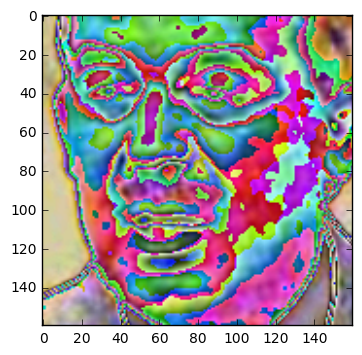

In [77]:
plt.imshow(face_images[0])
face_embeddings.shape
all_faces.shape

In [78]:
# # Use Tensorboard to find these embeddings
# from tensorflow.contrib.tensorboard.plugins import projector
# tf.InteractiveSession()
# # First create a sprite with all the images
# # face_images_cv2 = [cv2.cvtColor(face, cv2.COLOR_RGB2BGR) for face in face_images]
# # cv2.imwrite('Tensorboard/sprite.png', np.hstack(face_images_cv2))

# # Create a variable to hold the embeddings and assign them
# MODEL_DIR = "20170216-091149"
# with tf.Graph().as_default():
#     with tf.Session().as_default() as sess: 
        
#         # Importing the graph 
#         meta_file, ckpt_file = facenet.get_model_filenames(MODEL_DIR)
#         model_dir_exp = os.path.expanduser(MODEL_DIR)
#         print("importing model")
#         saver = tf.train.import_meta_graph(os.path.join(model_dir_exp, meta_file))
#         print("restoring model")
#         saver.restore(tf.get_default_session(), os.path.join(model_dir_exp, ckpt_file))
        
#         # Retrieving needed layers
#         images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
#         embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
#         phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0") 
# #         print([op.name for op in tf.get_default_graph().get_operations()])
        
#         # Create variables needed for Tensorboard
# #         embedding = tf.Variable(tf.zeros([33, 128]), name = "embedding") 
# #         assignment = embedding.assign(embeddings)
        
# #         # Create writer class
# #         writer = tf.summary.FileWriter(os.path.join(MODEL_DIR, "model"))
# #         writer.add_graph(sess.graph)
        
# #         # Setup the embeddings
# #         embedding_config = config.embeddings.add()
# #         embedding_config.tensor_name = embedding.name
# #         embedding_config.metadata_path = os.path.join(os.getcwd(), MODEL_DIR, 'labels.tsv')
# #         embedding_config.sprite.image_path = os.path.join(os.getcwd(), MODEL_DIR,'sprite.png')
# #         embedding_config.sprite.single_image_dim.extend([160, 160])
# #         projector.visualize_embeddings(writer, config)
        
#         # Create the embeddings
#         face_embedding = sess.run(embeddings, feed_dict = {images_placeholder : [face_images[0]], phase_train_placeholder : False})
#         print(face_embedding)
# #         print(face_embedding.eval())

In [79]:
# Use PCA to reduce dimensions
pca = PCA(n_components = 50)
face_embeddings_reduced = pca.fit_transform(face_embeddings)

# Use tSNE to project down to 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 25, learning_rate= 10)
tsne_embeddings = tsne.fit_transform(face_embeddings_reduced)
tsne_embeddings.shape

# # Add the embeddings
for i, tsne_embedding in enumerate(tsne_embeddings):
    all_faces[i].embedding = tsne_embedding

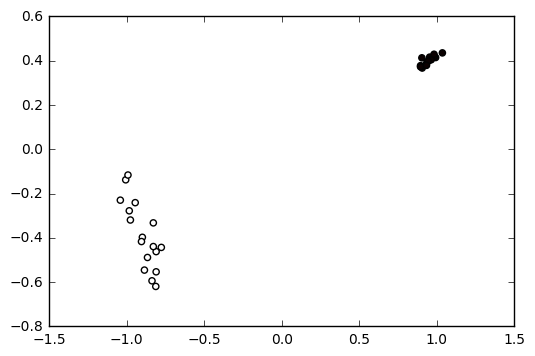

In [80]:
# Look at the plot in 2d
from sklearn import preprocessing
x = [face.embedding[0] for face in all_faces]
y = [face.embedding[1] for face in all_faces]
labels = [face.name_of_face for face in all_faces]
le = preprocessing.LabelEncoder()
le.fit(labels)
numerical_labels = le.transform(labels)
plt.scatter(x, y, c=numerical_labels, cmap = 'hot')
# plt.show()

## Clustering

In [81]:
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist, squareform

#### K-means cluster

In [82]:
clusterer = KMeans(n_clusters = 2, random_state = 10)
cluster_labels = clusterer.fit_predict(tsne_embeddings) 

In [83]:
def assign_labels(faces, labels):
    for i, label in enumerate(labels):
        faces[i].label = label
    return(faces)

In [84]:
# Assign faces to clusters
faces_with_embeddings_clusters = assign_labels(all_faces, cluster_labels)

In [85]:
# See what the clusters are like
clusters = {}
for face in all_faces:
    face_label = face.label
    if face_label not in clusters:
        clusters[face_label] = [face]
    else:
        clusters[face_label].append(face)

In [86]:
for cluster_label, faces in clusters.items():
    faces_in_cluster_label = {}
    for face in faces:
        name = face.name_of_face
        if name not in faces_in_cluster_label:
            faces_in_cluster_label[name] = 1
        else:
            faces_in_cluster_label[name] += 1
    print("Cluster {} has individuals: {}".format(cluster_label, faces_in_cluster_label))

Cluster 0 has individuals: {'Abdullah_Gul': 16}
Cluster 1 has individuals: {'Bill_Gates': 17}


#### Affinity Propagation clustering

In [87]:
clusterer = AffinityPropagation().fit(tsne_embeddings)
# print(clusterer.cluster_centers_indices_)
cluster_labels = clusterer.labels_
# print(clusterer.affinity_matrix_)

In [88]:
faces_with_embeddings_clusters = assign_labels(all_faces, cluster_labels)

In [89]:
# See what the clusters are like
clusters = {}
for face in all_faces:
    face_label = face.label
    if face_label not in clusters:
        clusters[face_label] = [face]
    else:
        clusters[face_label].append(face)

In [90]:
for cluster_label, faces in clusters.items():
    faces_in_cluster_label = {}
    for face in faces:
        name = face.name_of_face
        if name not in faces_in_cluster_label:
            faces_in_cluster_label[name] = 1
        else:
            faces_in_cluster_label[name] += 1
    print("Cluster {} has individuals: {}\n".format(cluster_label, faces_in_cluster_label))

Cluster 0 has individuals: {'Abdullah_Gul': 16}

Cluster 1 has individuals: {'Bill_Gates': 7}

Cluster 2 has individuals: {'Bill_Gates': 10}



#### Rank-Order Clustering

In [91]:
# First create a nearest neighbours list for all the faces using euclidean distance

In [92]:
import scipy

class Neighbour:
    def __init__(self, face, distance):
        self.face = face
        self.distance = distance

In [93]:
# Create nearest neighbours list of absolute distance
def assign_euclidean_neighbours(all_faces):
    for i, face1 in enumerate(all_faces):
        nearest_neighbour = []
        for j, face2 in enumerate(all_faces):
            distance = scipy.spatial.distance.euclidean(face1.embedding, face2.embedding)
            neighbour = Neighbour(face2, distance)
            nearest_neighbour.append(neighbour)
        nearest_neighbour.sort(key = lambda x: x.distance)
        face1.euclidean_neighbours = nearest_neighbour 

In [94]:
assign_euclidean_neighbours(all_faces)
for n in all_faces[1].euclidean_neighbours:
    print(n.face.name_of_face)
    print(n.distance)

Abdullah_Gul
0.0
Abdullah_Gul
0.00810554648720897
Abdullah_Gul
0.008235192477149064
Abdullah_Gul
0.012101149110153834
Abdullah_Gul
0.012734433256134358
Abdullah_Gul
0.021542533052557558
Abdullah_Gul
0.03327050973860076
Abdullah_Gul
0.0348912510873658
Abdullah_Gul
0.035709302902506505
Abdullah_Gul
0.03615218798063295
Abdullah_Gul
0.04023494220092387
Abdullah_Gul
0.04929501116132083
Abdullah_Gul
0.06233862691964943
Abdullah_Gul
0.06532686985688076
Abdullah_Gul
0.06781226060122729
Abdullah_Gul
0.08762285793449003
Bill_Gates
1.9280474257711875
Bill_Gates
1.9293492909062713
Bill_Gates
1.9664554999543509
Bill_Gates
1.9729100315687946
Bill_Gates
2.006387180914225
Bill_Gates
2.0085577846341
Bill_Gates
2.0146356270429533
Bill_Gates
2.0199282304589103
Bill_Gates
2.0282903456417434
Bill_Gates
2.032924022146086
Bill_Gates
2.0344372827889936
Bill_Gates
2.042947255436405
Bill_Gates
2.051505020231078
Bill_Gates
2.0546715531742077
Bill_Gates
2.0621044051463664
Bill_Gates
2.0716005463818212
Bill_Gates


In [116]:
def find_asym_rank_order(face1, face2):
    penalty = 0
    for i, neighbour1 in enumerate(face1.euclidean_neighbours):
#         print("i is: {}".format(i))
        for j, neighbour2 in enumerate(face2.euclidean_neighbours):
#             print("j is: {}".format(j))
            if neighbour1.face is neighbour2.face:
#                 print("found match")
#                 print("add penalty: {}".format(j))
                if j == 0: # this means that we found the rank of face2 in face1's neighbouts
                    return(penalty, i + 1)
                else:
                    penalty += j
#         print("penalty is: {}".format(penalty))
    return(penalty, i+1)
    
def find_rank_order(face1, face2):
    
    distance_face1_face2, num_neighbours_face1 = find_asym_rank_order(face1, face2)
    distance_face2_face1, num_neighbours_face2 = find_asym_rank_order(face2, face1)
    min_neighbours = min(num_neighbours_face1, num_neighbours_face2)
    return((distance_face1_face2 + distance_face2_face1)/min_neighbours)

# print(len(all_faces))
for face1 in all_faces:
    nearest_neighbours = []
    for face2 in all_faces:
        
        # Get rank order distance between face1 and face 2
        rank_order = find_rank_order(face1, face2)
        nearest_neighbours.append(Neighbour(face2, rank_order))

    nearest_neighbours.sort(key = lambda x : x.distance)
    face1.rank_order_neighbours = nearest_neighbours 

In [117]:
index = 34
plt.imshow(all_faces[index].face_image)
for ro_neighbour in all_faces[index].rank_order_neighbours: 
    print(ro_neighbour.face.name_of_face)
    print(ro_neighbour.distance)

IndexError: index 34 is out of bounds for axis 0 with size 33